<a href="https://colab.research.google.com/github/yoouza/bigcontest/blob/master/data_analysis/Various_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 데이터 불러오기
- 서울에 해당하는 중구(140), 노원구(350)를 사용합니다.
- 다음의 카테고리(MCT_CAT_CD) 별로 모델을 학습하기 위해 총 9가지로 데이터를 분리합니다.

#### 온라인 서비스
1. 가구(30), 주방용구(32)
2. 가전(35), 사무통신(52)
3. 레저용품(20)
4. 신변잡화(44)
5. 음료식품(81)
6. 의복(42)

#### 오프라인 서비스
7. 숙박(10)
8. 유통업(40)
9. 요식업소(80)

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import gc
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime, timedelta
from google.colab import drive
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
# drive.mount('/content/drive')

# 그래프 한글 출력 설정
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf
plt.rc('font', family='NanumBarunGothic') 

data = pd.read_csv('/content/drive/My Drive/CARD_SPENDING_RESIDENT.csv', sep='\t')
data_foreigner = pd.read_csv('/content/drive/My Drive/CARD_SPENDING_FOREIGNER.txt', sep='\t', encoding='cp949')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# 국내
jung = data[data.GU_CD == 140].reset_index(drop = True)
nowon = data[data.GU_CD == 350].reset_index(drop = True)

seoul = pd.concat([jung, nowon])
seoul['STD_DD'] = seoul.STD_DD.apply(lambda x: datetime.strptime(str(x), '%Y%m%d'))
seoul2019 = seoul[seoul.STD_DD < '2020-01-01']
seoul2020 = seoul[seoul.STD_DD > '2020-01-01']

In [4]:
# 외국인
jung_foreigner = data_foreigner[data_foreigner.GU_CD == 140].reset_index(drop = True)
nowon_foreigner = data_foreigner[data_foreigner.GU_CD == 350].reset_index(drop = True)

foreigner = pd.concat([jung_foreigner, nowon_foreigner])
foreigner['STD_DD'] = foreigner.STD_DD.apply(lambda x: datetime.strptime(str(x), '%Y%m%d'))
foreigner2019 = foreigner[foreigner.STD_DD < '2020-01-01']
foreigner2020 = foreigner[foreigner.STD_DD > '2020-01-01']

In [5]:
# 국내 + 외국인 합치기
def indexing(df):
    return df.groupby(['STD_DD', 'MCT_CAT_CD'])[['USE_CNT', 'USE_AMT']].sum()

def sum_korean_foreigner(df_korean, df_foreigner):
    df_foreigner.columns = ['USE_CNT2', 'USE_AMT2']
    df_all = pd.concat([df_korean, df_foreigner], axis=1)
    df_all['USE_CNT_SUM'] = np.nansum([df_all['USE_CNT'], df_all['USE_CNT2']], axis=0)
    df_all['USE_AMT_SUM'] = np.nansum([df_all['USE_AMT'], df_all['USE_AMT2']], axis=0)
    df_all = df_all[['USE_CNT_SUM', 'USE_AMT_SUM']]
    df_all.columns = ['USE_CNT', 'USE_AMT']
    return df_all.reset_index()

seoul2019 = indexing(seoul2019)
seoul2020 = indexing(seoul2020)
foreigner2019 = indexing(foreigner2019)
foreigner2020 = indexing(foreigner2020)

df_2019 = sum_korean_foreigner(seoul2019, foreigner2019)
df_2020 = sum_korean_foreigner(seoul2020, foreigner2020)

# 변수 추가하기
1. 전국 코로나 신규 확진자 수
2. 사회/경제 뉴스
3. 날짜 변수

In [6]:
# 코로나
covid = pd.read_csv('/content/drive/My Drive/COVID-19_TimeProvince.csv')
covid = covid.groupby('date').sum().reset_index()
covid['date'] = covid.date.apply(lambda x: datetime.strptime(str(x), '%Y-%m-%d'))
covid = covid[covid.date < '2020-06-01'][covid.date >= '2020-01-31']
covid = covid.rename(columns = {'date': 'STD_DD'})
covid['covid'] = 0
covid['covid'][1:] = covid['confirmed'].values[1:] - covid['confirmed'][:-1].values
covid = covid[1:]
df_2020 = pd.merge(df_2020, covid[['STD_DD', 'covid']])
df_2019['covid'] = 0

In [7]:
# 뉴스
news = pd.read_csv('/content/drive/My Drive/news_predict_new.csv')
news['STD_DD'] = news['Unnamed: 0'].apply(lambda x: datetime.strptime(str(x), '%Y-%m-%d'))
news['STD_DD'] = news['STD_DD'] - timedelta(days = 7)

In [8]:
# 날짜 변수
def date_features(df):
    df['dayofweek'] = df.STD_DD.dt.dayofweek
    # df['quarter'] = df['date'].dt.quarter
    df['month'] = df.STD_DD.dt.month
    # df['year'] = df['date'].dt.year
    df['dayofyear'] = df.STD_DD.dt.dayofyear
    df['dayofmonth'] = df.STD_DD.dt.day
    df['weekofyear'] = df.STD_DD.dt.weekofyear
    return df

df_2019 = date_features(df_2019)
df_2020 = date_features(df_2020)

# Preprocessing 함수 정의
- Test set: 5월 마지막 주
- rolling window 적용하기

In [9]:
# 7일 동안의 데이터를 바탕으로 다음 일주일 매출을 예측 (rolling window)
def preprocessing(df):
    amt_X, amt_y = [], []
    cnt_X, covid_X, news_X = [], [], []
    dayofweek, month, dayofyear, dayofmonth, weekofyear = [], [], [], [], []

    for i in range(len(df)-14+1):

        # 추가 변수
        amt_X.append(df.USE_AMT[i:i+7].values)
        cnt_X.append(df.USE_CNT[i:i+7].values)
        covid_X.append(df.covid[i:i+7].values)
        news_X.append(df.news[i:i+7].values)

        # 날짜 변수
        dayofweek.append(df.dayofweek[i:i+7].values)
        month.append(df.month[i:i+7].values)
        dayofyear.append(df.dayofyear[i:i+7].values)
        dayofmonth.append(df.dayofmonth[i:i+7].values)
        weekofyear.append(df.weekofyear[i:i+7].values)

        # 예측값
        amt_y.append(df.USE_AMT[i+7:i+14].values)

    amt_X = np.array(amt_X)
    cnt_X = np.array(cnt_X)
    covid_X = np.array(covid_X)
    news_X = np.array(news_X)

    dow = np.array(dayofweek)
    month = np.array(month)
    doy = np.array(dayofyear)
    dom = np.array(dayofmonth)
    woy = np.array(weekofyear)

    amt_y = np.array(amt_y)

    X = np.concatenate([amt_X.reshape(-1, 7, 1), cnt_X.reshape(-1, 7, 1), covid_X.reshape(-1, 7, 1), news_X.reshape(-1, 7, 1),
                        dow.reshape(-1, 7, 1), month.reshape(-1, 7, 1), doy.reshape(-1, 7, 1), dom.reshape(-1, 7, 1), woy.reshape(-1, 7, 1)], axis=2)
    y = amt_y

    return X, y

In [10]:
# 카테고리 번호로 데이터 뽑아내기
def set_category(df, category_num):
    return df[df.MCT_CAT_CD == category_num].groupby('STD_DD').sum().drop('MCT_CAT_CD', axis=1).reset_index()

- 카테고리가 2개 이상인 것들 먼저 저장

In [11]:
df = []
df2 = []

# 1. 가구, 주방용구
# 2019
tmp1 = set_category(df_2019, 30)
tmp2 = set_category(df_2019, 32)
tmp2.loc[4] = [datetime.strptime('2019-02-05', '%Y-%m-%d'), 0, 0, 0, 1, 2, 36, 5, 6] # 2019-02-05 결측값이 있어서 채워줌
tmp_cnt = tmp1.USE_CNT + tmp2.USE_CNT
tmp_amt = tmp1.USE_AMT + tmp2.USE_AMT
tmp1['USE_CNT'] = tmp_cnt
tmp1['USE_AMT'] = tmp_amt
tmp1 = pd.merge(tmp1, news[['STD_DD', '30_32']]).rename(columns = {'30_32': 'news'})
df.append(tmp1)
# 2020
tmp1 = set_category(df_2020, 30)
tmp2 = set_category(df_2020, 32)
tmp_cnt = tmp1.USE_CNT + tmp2.USE_CNT
tmp_amt = tmp1.USE_AMT + tmp2.USE_AMT
tmp1['USE_CNT'] = tmp_cnt
tmp1['USE_AMT'] = tmp_amt
tmp1 = pd.merge(tmp1, news[['STD_DD', '30_32']]).rename(columns = {'30_32': 'news'})
df2.append(tmp1)

# 2. 가전, 사무통신
# 2019
tmp1 = set_category(df_2019, 35)
tmp2 = set_category(df_2019, 52)
tmp_cnt = tmp1.USE_CNT + tmp2.USE_CNT
tmp_amt = tmp1.USE_AMT + tmp2.USE_AMT
tmp1['USE_CNT'] = tmp_cnt
tmp1['USE_AMT'] = tmp_amt
tmp1 = pd.merge(tmp1, news[['STD_DD', '35_52']]).rename(columns = {'35_52': 'news'})
df.append(tmp1)
# 2020
tmp1 = set_category(df_2020, 35)
tmp2 = set_category(df_2020, 52)
tmp_cnt = tmp1.USE_CNT + tmp2.USE_CNT
tmp_amt = tmp1.USE_AMT + tmp2.USE_AMT
tmp1['USE_CNT'] = tmp_cnt
tmp1['USE_AMT'] = tmp_amt
tmp1 = pd.merge(tmp1, news[['STD_DD', '35_52']]).rename(columns = {'35_52': 'news'})
df2.append(tmp1)

- 그 외 카테고리 1개인 것들 저장

In [12]:
n_categories = [10, 20, 40, 42, 44, 80, 81]

for n_category in n_categories:
    # 2019
    tmp = set_category(df_2019, n_category)
    tmp = pd.merge(tmp, news[['STD_DD', str(n_category)]]).rename(columns = {str(n_category): 'news'})
    df.append(tmp)

    # 2020
    tmp2 = set_category(df_2020, n_category)
    tmp2 = pd.merge(tmp2, news[['STD_DD', str(n_category)]]).rename(columns = {str(n_category): 'news'})
    df2.append(tmp2)

# 1. XGBoost

### Train
Grid Search CV 이용해서 최적의 Parameter 찾기

In [13]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

param_grid = {'estimator__min_samples_split':[10, 50],
              'estimator__min_samples_leaf':[50, 150],
              'estimator__max_depth': [5, 6, 7, 8, 9, 10]}

# xgb_cv = []
xgb_pred = []
xgb_score = []
train_y, test_y = [], []

for i in tqdm(range(9)):
    X, y = preprocessing(df[i])
    X2, y2 = preprocessing(df2[i])

    # 2019, 2020 합치기
    X = np.concatenate([X, X2])
    y = np.concatenate([y, y2])

    # XGBoost는 3차원을 인식 못하므로 2차원으로 펴주는 과정 필요
    X_train, y_train, X_test, y_test = X[:-7], y[:-7], X[-7:], y[-7:]
    X_train = X_train.reshape(len(X_train), -1) 
    X_test = X_test.reshape(len(X_test), -1)

    train_y.append(y_train[-1]) # 5/17 ~ 5/24
    test_y.append(y_test[-1]) # 5/25 ~ 5/31

    gb = xgb.XGBRegressor(objective='reg:squarederror')
    gs = GridSearchCV(MultiOutputRegressor(gb), param_grid=param_grid, cv = 3)
    gs.fit(X_train, y_train)

    gs_xgb = gs.best_estimator_
    gs_xgb.fit(X_train, y_train)

    # kf = KFold(n_splits = 5)
    # scores = []
    # for train_index, test_index in kf.split(X_train):
    #     gs_xgb = gs.best_estimator_
    #     gs_xgb.fit(X_train[train_index], y_train[train_index])
    #     pred = gs_xgb.predict(X_train[test_index])
    #     scores.append(mean_absolute_percentage_error(y_train[test_index], pred))

    y_pred = gs_xgb.predict(X_test)
    xgb_pred.append(y_pred[-1]) # 각 카테고리의 Prediction 값(마지막 주)
    xgb_score.append(mean_absolute_percentage_error(y_test, y_pred)) # 각 카테고리의 Test Score
    # xgb_cv.append(np.mean(scores))
    
    del gb, gs, gs_xgb
    gc.collect()

100%|██████████| 9/9 [07:47<00:00, 51.94s/it]


### Prediction
- 각 카테고리 예상 매출의 MAPE(Mean Squared Percentage Error)값

In [14]:
xgb_score

[31.00459370295533,
 16.99321953458842,
 21.830314925041453,
 23.188636509117547,
 11.329861760636012,
 26.07763127996688,
 24.414456677367095,
 11.032989972487298,
 24.30826701764288]

### 시각화

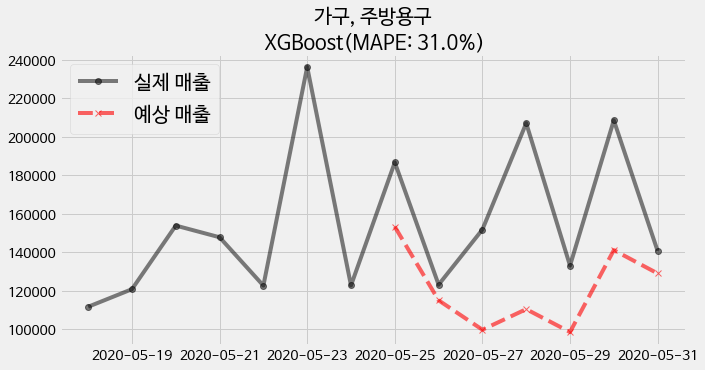

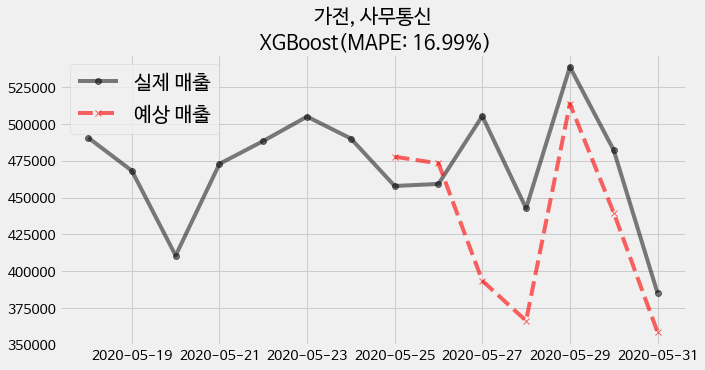

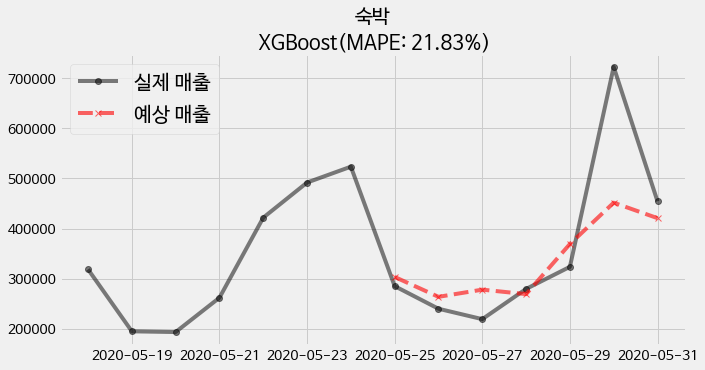

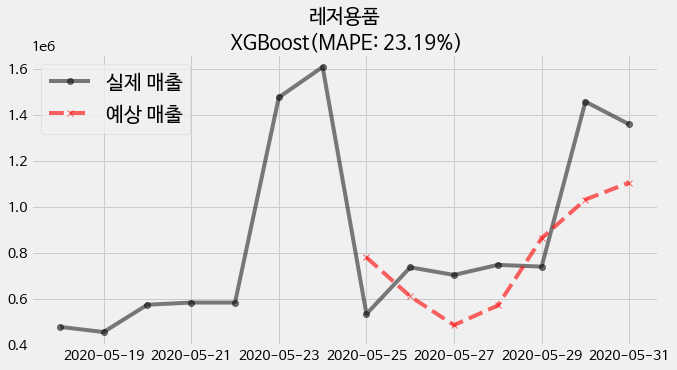

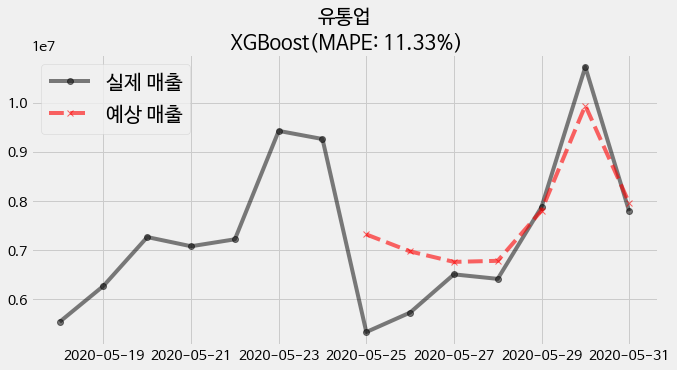

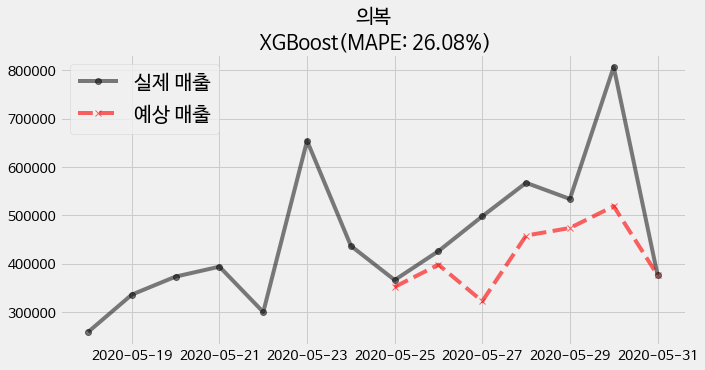

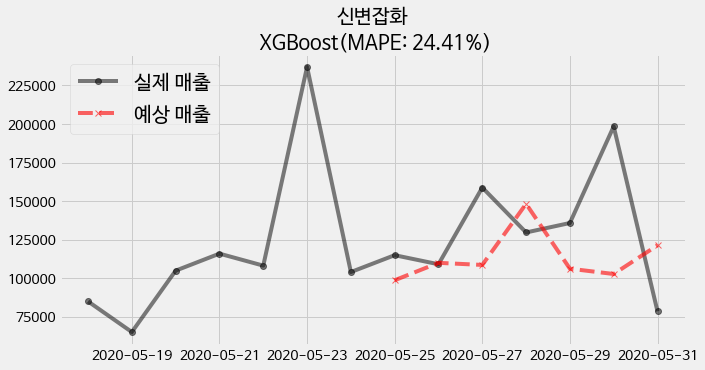

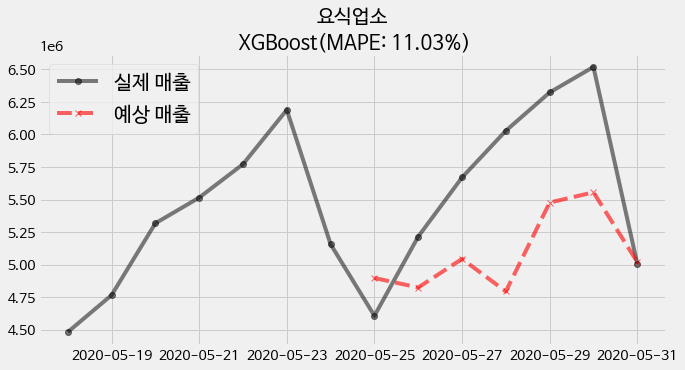

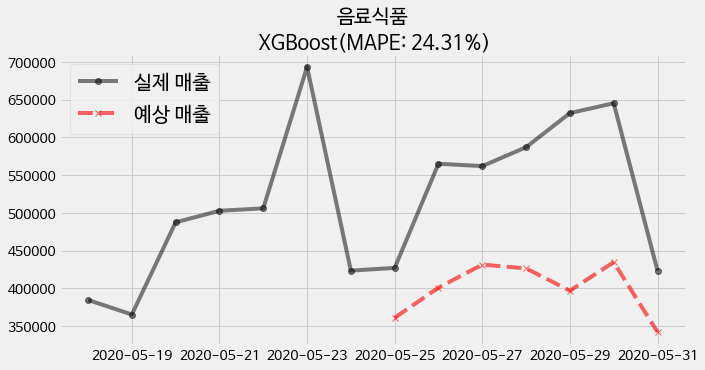

In [15]:
dates = covid.STD_DD.values[-14:]
names = ['가구, 주방용구', '가전, 사무통신', '숙박', '레저용품', '유통업', '의복', '신변잡화', '요식업소', '음료식품']

for i in range(9):
    # 5/17 ~ 5/31의 실제 매출
    real_amt = list(train_y[i]) + list(test_y[i]) 
    # 5/25 ~ 5/31 예상 매출
    pred_amt = xgb_pred[i]

    plt.figure(figsize=(10,5))
    plt.plot(dates, real_amt, marker = 'o', color = 'black', label = '실제 매출', alpha = 0.5)
    plt.plot(dates[7:], pred_amt, color = 'red', label = '예상 매출', marker = 'x', ls = '--', alpha = 0.6)
    plt.legend(loc = 'upper left', fontsize = 'x-large')
    plt.title(f"{names[i]}\n XGBoost(MAPE: {round(xgb_score[i], 2)}%)", size = 20)
    plt.show()

# 2. LSTM

### Train

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset,DataLoader
import torch.optim as optim
torch.manual_seed(1015)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class LSTMModel_trend(nn.Module):
    def __init__(self, input_size, hidden_size):
        # time model
        super(LSTMModel_trend, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        
        # merge model
        self.time_fc = nn.Sequential(
            nn.Linear(hidden_size, 14),
            nn.ReLU(inplace=True),
            nn.Linear(14,14),
            nn.ReLU(inplace=True),
            nn.Linear(14,7)
        )
        
    def forward(self, x_time):
        # time part
        hidden = (
            torch.zeros(1, x_time.size(0), self.hidden_size).to(device),
            torch.zeros(1, x_time.size(0), self.hidden_size).to(device)
        )
        
        out, _ = self.lstm(x_time, hidden)
        out = out[:, -1, :] # LSTM의 output은 모든 출력값인데 마지막 값만 받는다.
        out = self.time_fc(out.view(-1, self.hidden_size)) # 3 -> 2차원
        
        return out

In [22]:
cols = list(df[0].columns[1:])
lstm_pred = []
lstm_score = []
train_y, test_y = [], []

for i in tqdm(range(9)):
    # 정규화
    for col in cols:
        if col != 'news':
            scaler = MinMaxScaler(feature_range = (0, 1))
            scaled_values = scaler.fit_transform(df[i][col].values.reshape(-1, 1))
            scaled_values2 = scaler.fit_transform(df2[i][col].values.reshape(-1, 1))
            df[i][col] = scaled_values
            df2[i][col] = scaled_values2
        else:
            scaler = MinMaxScaler(feature_range = (-0.5, 0.5))
            scaled_values = scaler.fit_transform(df[i][col].values.reshape(-1, 1))
            scaled_values2 = scaler.fit_transform(df2[i][col].values.reshape(-1, 1))
            df[i][col] = scaled_values
            df2[i][col] = scaled_values2

    X, y = preprocessing(df[i])
    X2, y2 = preprocessing(df2[i])

    # 2019, 2020 합치기
    X = np.concatenate([X, X2])
    y = np.concatenate([y, y2])

    X_train, y_train, X_test, y_test = X[:-7], y[:-7], X[-7:], y[-7:]

    train_y.append(y_train[-1]) # 5/17 ~ 5/24
    test_y.append(y_test[-1]) # 5/25 ~ 5/31

    X = torch.FloatTensor(X_train).to(device)
    y = torch.FloatTensor(y_train).to(device)

    # hidden state : 전달과정 중간 출력의 차원
    # model_trend = LSTMModel_trend(input_size = 4, hidden_size = 32).to(device)
    model_trend = LSTMModel_trend(input_size = 9, hidden_size = 32).to(device)
    optimizer = torch.optim.Adam(model_trend.parameters(), lr = 1e-2)
    criterion = nn.MSELoss(size_average = True)

    # Train model
    num_epochs  = 200
    hist = np.zeros(num_epochs)

    # Number of steps to unroll
    look_back = 7
    seq_dim =look_back - 1

    for t in range(num_epochs):
        pred = model_trend(X)
        loss = criterion(pred, y)

        if t % 10 == 0 and t !=0:
            print("Epoch ", t, "MSE: ", loss.item())
        hist[t] = loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    y_pred = model_trend(torch.FloatTensor(X_test).to(device))
    lstm_pred.append(y_pred[-1].cpu().detach().numpy()) # 각 카테고리의 Prediction 값(마지막 주)
    lstm_score.append(mean_absolute_percentage_error(y_test, y_pred.cpu().detach().numpy())) # 각 카테고리의 Test Score

    del X, y
    gc.collect()


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch  10 MSE:  0.13712304830551147
Epoch  20 MSE:  0.07524331659078598
Epoch  30 MSE:  0.0355612188577652
Epoch  40 MSE:  0.029268160462379456
Epoch  50 MSE:  0.02818918041884899
Epoch  60 MSE:  0.02776256389915943
Epoch  70 MSE:  0.027383053675293922
Epoch  80 MSE:  0.0268563162535429
Epoch  90 MSE:  0.02603711187839508
Epoch  100 MSE:  0.025108978152275085
Epoch  110 MSE:  0.024043401703238487
Epoch  120 MSE:  0.022799769416451454
Epoch  130 MSE:  0.021067889407277107
Epoch  140 MSE:  0.01967080868780613
Epoch  150 MSE:  0.018767347559332848
Epoch  160 MSE:  0.01792793720960617
Epoch  170 MSE:  0.017052721232175827
Epoch  180 MSE:  0.016529656946659088
Epoch  190 MSE:  0.01612246409058571



 11%|█         | 1/9 [00:01<00:08,  1.08s/it]

Epoch  10 MSE:  0.037102650851011276
Epoch  20 MSE:  0.028240259736776352
Epoch  30 MSE:  0.024385202676057816
Epoch  40 MSE:  0.020747175440192223
Epoch  50 MSE:  0.01844305917620659
Epoch  60 MSE:  0.016262875869870186
Epoch  70 MSE:  0.015466361306607723
Epoch  80 MSE:  0.014690053649246693
Epoch  90 MSE:  0.014042976312339306
Epoch  100 MSE:  0.013846381567418575
Epoch  110 MSE:  0.013648461550474167
Epoch  120 MSE:  0.013454976491630077
Epoch  130 MSE:  0.01417242456227541
Epoch  140 MSE:  0.013608491979539394
Epoch  150 MSE:  0.013075613416731358
Epoch  160 MSE:  0.012842761352658272
Epoch  170 MSE:  0.012645209208130836
Epoch  180 MSE:  0.012392976321280003
Epoch  190 MSE:  0.012131057679653168



 22%|██▏       | 2/9 [00:02<00:07,  1.04s/it]

Epoch  10 MSE:  0.07080364972352982
Epoch  20 MSE:  0.037817008793354034
Epoch  30 MSE:  0.02492552064359188
Epoch  40 MSE:  0.02176649309694767
Epoch  50 MSE:  0.020370233803987503
Epoch  60 MSE:  0.018866753205657005
Epoch  70 MSE:  0.016952453181147575
Epoch  80 MSE:  0.015204661525785923
Epoch  90 MSE:  0.013314582407474518
Epoch  100 MSE:  0.01150588784366846
Epoch  110 MSE:  0.009331075474619865
Epoch  120 MSE:  0.007319889962673187
Epoch  130 MSE:  0.0062528434209525585
Epoch  140 MSE:  0.005657336208969355
Epoch  150 MSE:  0.005010149907320738
Epoch  160 MSE:  0.004844634793698788
Epoch  170 MSE:  0.0044848439283668995
Epoch  180 MSE:  0.0042480179108679295
Epoch  190 MSE:  0.00404562009498477



 33%|███▎      | 3/9 [00:03<00:06,  1.02s/it]

Epoch  10 MSE:  0.06852782517671585
Epoch  20 MSE:  0.0473310612142086
Epoch  30 MSE:  0.044410474598407745
Epoch  40 MSE:  0.03731176629662514
Epoch  50 MSE:  0.03129919618368149
Epoch  60 MSE:  0.02553330734372139
Epoch  70 MSE:  0.019777553156018257
Epoch  80 MSE:  0.016369584947824478
Epoch  90 MSE:  0.014436013996601105
Epoch  100 MSE:  0.012446188367903233
Epoch  110 MSE:  0.010988057591021061
Epoch  120 MSE:  0.009576670825481415
Epoch  130 MSE:  0.007901844568550587
Epoch  140 MSE:  0.00692262127995491
Epoch  150 MSE:  0.006364212837070227
Epoch  160 MSE:  0.00584299536421895
Epoch  170 MSE:  0.00709322327747941
Epoch  180 MSE:  0.005528515670448542
Epoch  190 MSE:  0.004966094624251127



 44%|████▍     | 4/9 [00:03<00:05,  1.00s/it]

Epoch  10 MSE:  0.09026538580656052
Epoch  20 MSE:  0.04831406846642494
Epoch  30 MSE:  0.04226125404238701
Epoch  40 MSE:  0.03418771177530289
Epoch  50 MSE:  0.03200463205575943
Epoch  60 MSE:  0.030172398313879967
Epoch  70 MSE:  0.028776969760656357
Epoch  80 MSE:  0.025064608082175255
Epoch  90 MSE:  0.022218281403183937
Epoch  100 MSE:  0.019816091284155846
Epoch  110 MSE:  0.014450257644057274
Epoch  120 MSE:  0.01157447975128889
Epoch  130 MSE:  0.009936656802892685
Epoch  140 MSE:  0.008982828818261623
Epoch  150 MSE:  0.008182640187442303
Epoch  160 MSE:  0.007551136426627636
Epoch  170 MSE:  0.006787777878344059
Epoch  180 MSE:  0.006315323989838362
Epoch  190 MSE:  0.005745127331465483



 56%|█████▌    | 5/9 [00:04<00:03,  1.02it/s]

Epoch  10 MSE:  0.052212271839380264
Epoch  20 MSE:  0.040491826832294464
Epoch  30 MSE:  0.0276151392608881
Epoch  40 MSE:  0.02145219035446644
Epoch  50 MSE:  0.019167881458997726
Epoch  60 MSE:  0.018178142607212067
Epoch  70 MSE:  0.017800090834498405
Epoch  80 MSE:  0.01746714487671852
Epoch  90 MSE:  0.016973532736301422
Epoch  100 MSE:  0.016054093837738037
Epoch  110 MSE:  0.014055327512323856
Epoch  120 MSE:  0.013296672143042088
Epoch  130 MSE:  0.012114300392568111
Epoch  140 MSE:  0.010664760135114193
Epoch  150 MSE:  0.009934290312230587
Epoch  160 MSE:  0.009263414889574051
Epoch  170 MSE:  0.008745874278247356
Epoch  180 MSE:  0.008332179859280586
Epoch  190 MSE:  0.008068826049566269



 67%|██████▋   | 6/9 [00:05<00:02,  1.03it/s]

Epoch  10 MSE:  0.05982936546206474
Epoch  20 MSE:  0.042565613985061646
Epoch  30 MSE:  0.039221201092004776
Epoch  40 MSE:  0.03789244592189789
Epoch  50 MSE:  0.03613412007689476
Epoch  60 MSE:  0.02971348538994789
Epoch  70 MSE:  0.025614045560359955
Epoch  80 MSE:  0.024065380915999413
Epoch  90 MSE:  0.022931234911084175
Epoch  100 MSE:  0.022083256393671036
Epoch  110 MSE:  0.021287985146045685
Epoch  120 MSE:  0.020668426528573036
Epoch  130 MSE:  0.020386891439557076
Epoch  140 MSE:  0.019542401656508446
Epoch  150 MSE:  0.019306829199194908
Epoch  160 MSE:  0.01892310008406639
Epoch  170 MSE:  0.018695544451475143
Epoch  180 MSE:  0.01844177395105362
Epoch  190 MSE:  0.018220704048871994



 78%|███████▊  | 7/9 [00:06<00:01,  1.04it/s]

Epoch  10 MSE:  0.045815609395504
Epoch  20 MSE:  0.046010226011276245
Epoch  30 MSE:  0.03946834057569504
Epoch  40 MSE:  0.03332982957363129
Epoch  50 MSE:  0.025522274896502495
Epoch  60 MSE:  0.023206034675240517
Epoch  70 MSE:  0.021915098652243614
Epoch  80 MSE:  0.021049045026302338
Epoch  90 MSE:  0.019973307847976685
Epoch  100 MSE:  0.01813839189708233
Epoch  110 MSE:  0.016641970723867416
Epoch  120 MSE:  0.015890656039118767
Epoch  130 MSE:  0.015106667764484882
Epoch  140 MSE:  0.0144049022346735
Epoch  150 MSE:  0.01355387270450592
Epoch  160 MSE:  0.012317831628024578
Epoch  170 MSE:  0.010635828599333763
Epoch  180 MSE:  0.009725821204483509
Epoch  190 MSE:  0.009187156334519386



 89%|████████▉ | 8/9 [00:07<00:00,  1.05it/s]

Epoch  10 MSE:  0.04974296689033508
Epoch  20 MSE:  0.023152422159910202
Epoch  30 MSE:  0.02037454955279827
Epoch  40 MSE:  0.018536033108830452
Epoch  50 MSE:  0.0185717660933733
Epoch  60 MSE:  0.018194779753684998
Epoch  70 MSE:  0.018145404756069183
Epoch  80 MSE:  0.018033264204859734
Epoch  90 MSE:  0.01795288361608982
Epoch  100 MSE:  0.017854657024145126
Epoch  110 MSE:  0.01775025762617588
Epoch  120 MSE:  0.01763908378779888
Epoch  130 MSE:  0.017539849504828453
Epoch  140 MSE:  0.017461322247982025
Epoch  150 MSE:  0.017408480867743492
Epoch  160 MSE:  0.01735815592110157
Epoch  170 MSE:  0.017300603911280632
Epoch  180 MSE:  0.01723337173461914
Epoch  190 MSE:  0.01715068891644478



100%|██████████| 9/9 [00:08<00:00,  1.04it/s]


### Prediction

In [23]:
lstm_score

[34.48444814923256,
 13.308218459387364,
 39.4415476798911,
 28.20431928203093,
 41.35216152160967,
 27.30526524820337,
 32.934369881003086,
 16.970402996399127,
 35.998464517390275]

### 시각화

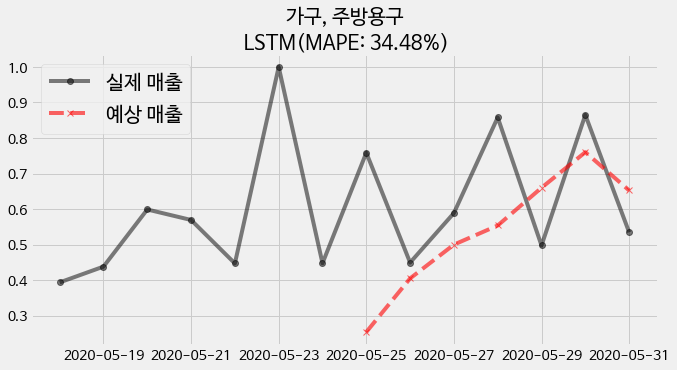

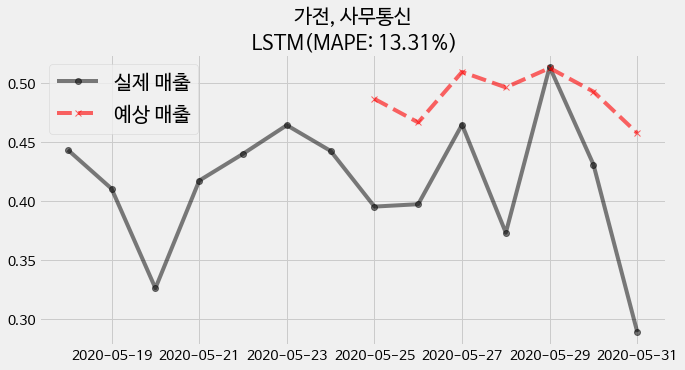

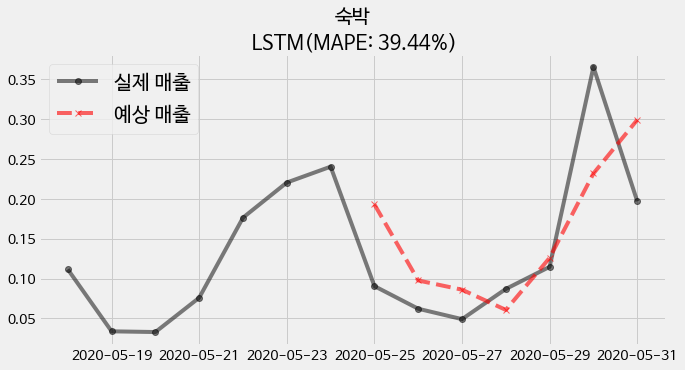

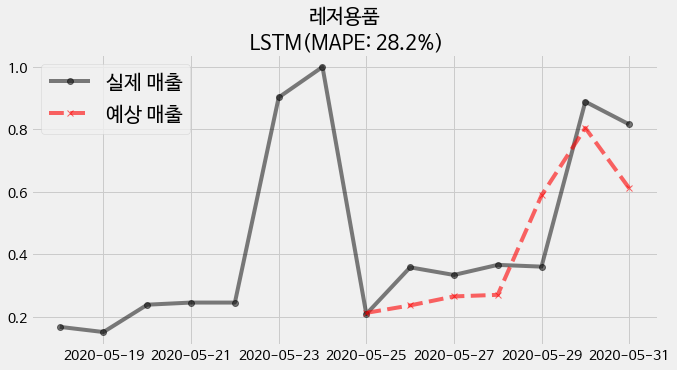

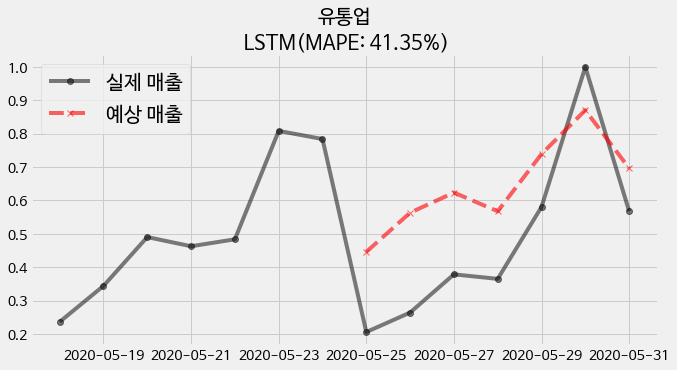

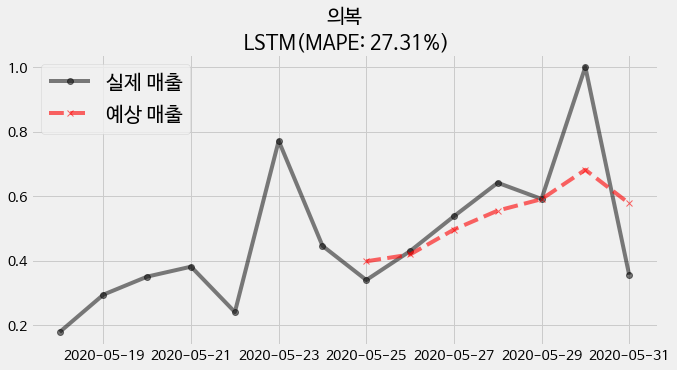

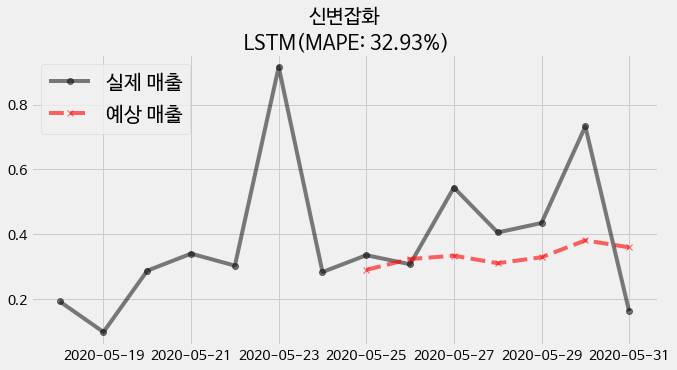

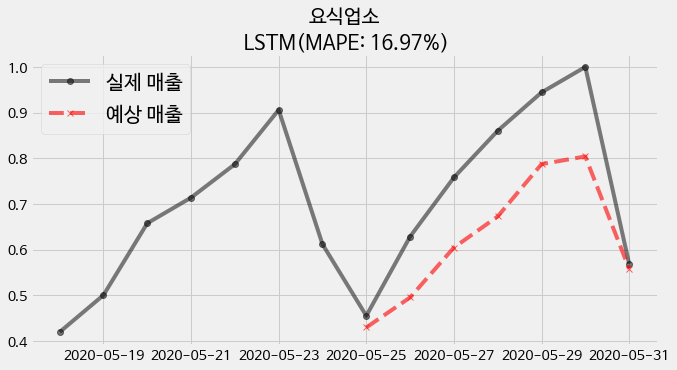

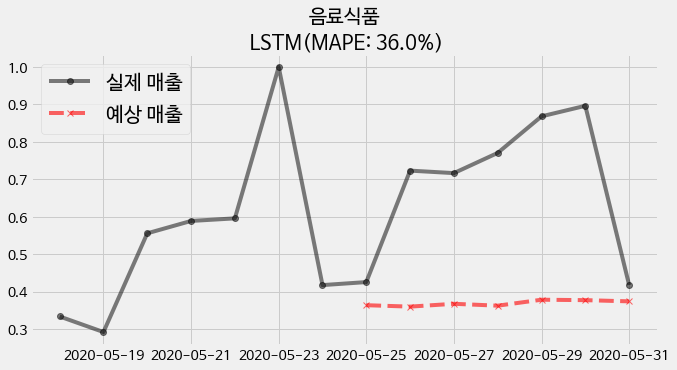

In [24]:
dates = covid.STD_DD.values[-14:]
names = ['가구, 주방용구', '가전, 사무통신', '숙박', '레저용품', '유통업', '의복', '신변잡화', '요식업소', '음료식품']

for i in range(9):
    # 5/17 ~ 5/31의 실제 매출
    real_amt = list(train_y[i]) + list(test_y[i]) 
    # 5/25 ~ 5/31 예상 매출
    pred_amt = lstm_pred[i]

    plt.figure(figsize=(10,5))
    plt.plot(dates, real_amt, marker = 'o', color = 'black', label = '실제 매출', alpha = 0.5)
    plt.plot(dates[7:], pred_amt, color = 'red', label = '예상 매출', marker = 'x', ls = '--', alpha = 0.6)
    plt.legend(loc = 'upper left', fontsize = 'x-large')
    plt.title(f"{names[i]}\n LSTM(MAPE: {round(lstm_score[i], 2)}%)", size = 20)
    plt.show()

# 3. GRU

### Train

In [25]:
class GRUModel_trend(nn.Module):
    def __init__(self, input_size, hidden_size):
        # time model
        super(GRUModel_trend, self).__init__()
        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        
        # merge model
        self.time_fc = nn.Sequential(
            nn.Linear(hidden_size, 14),
            nn.ReLU(inplace=True),
            nn.Linear(14,14),
            nn.ReLU(inplace=True),
            nn.Linear(14,7)
        )

    def forward(self, x_time):
        # time part
        # hidden = (
        #     torch.zeros(1, x_time.size(0), self.hidden_size).to(device),
        #     torch.zeros(1, x_time.size(0), self.hidden_size).to(device)
        # )
        
        out, _ = self.gru(x_time)
        out = out[:, -1, :] # GRU의 output은 모든 출력값인데 마지막 값만 받는다.
        out = self.time_fc(out.view(-1, self.hidden_size)) # 3 -> 2차원
        
        return out

In [26]:
cols = list(df[0].columns[1:])
gru_pred = []
gru_score = []
train_y, test_y = [], []

for i in tqdm(range(9)):
    # 정규화
    for col in cols:
        if col != 'news':
            scaler = MinMaxScaler(feature_range = (0, 1))
            scaled_values = scaler.fit_transform(df[i][col].values.reshape(-1, 1))
            scaled_values2 = scaler.fit_transform(df2[i][col].values.reshape(-1, 1))
            df[i][col] = scaled_values
            df2[i][col] = scaled_values2
        else:
            scaler = MinMaxScaler(feature_range = (-0.5, 0.5))
            scaled_values = scaler.fit_transform(df[i][col].values.reshape(-1, 1))
            scaled_values2 = scaler.fit_transform(df2[i][col].values.reshape(-1, 1))
            df[i][col] = scaled_values
            df2[i][col] = scaled_values2

    X, y = preprocessing(df[i])
    X2, y2 = preprocessing(df2[i])

    # 2019, 2020 합치기
    X = np.concatenate([X, X2])
    y = np.concatenate([y, y2])

    X_train, y_train, X_test, y_test = X[:-7], y[:-7], X[-7:], y[-7:]

    train_y.append(y_train[-1]) # 5/17 ~ 5/24
    test_y.append(y_test[-1]) # 5/25 ~ 5/31

    X = torch.FloatTensor(X_train).to(device)
    y = torch.FloatTensor(y_train).to(device)

    # hidden state : 전달과정 중간 출력의 차원
    # model_trend = GRUModel_trend(input_size = 4, hidden_size = 32).to(device)
    model_trend = GRUModel_trend(input_size = 9, hidden_size = 32).to(device)
    optimizer = torch.optim.Adam(model_trend.parameters(), lr = 1e-2)
    criterion = nn.MSELoss(size_average = True)

    # Train model
    num_epochs  = 200
    hist = np.zeros(num_epochs)

    # Number of steps to unroll
    look_back = 7
    seq_dim =look_back - 1

    for t in range(num_epochs):
        pred = model_trend(X)
        loss = criterion(pred, y)

        if t % 10 == 0 and t !=0:
            print("Epoch ", t, "MSE: ", loss.item())
        hist[t] = loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    y_pred = model_trend(torch.FloatTensor(X_test).to(device))
    gru_pred.append(y_pred[-1].cpu().detach().numpy()) # 각 카테고리의 Prediction 값(마지막 주)
    gru_score.append(mean_absolute_percentage_error(y_test, y_pred.cpu().detach().numpy())) # 각 카테고리의 Test Score

    del X, y
    gc.collect()


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch  10 MSE:  0.04293162003159523
Epoch  20 MSE:  0.037364933639764786
Epoch  30 MSE:  0.030257802456617355
Epoch  40 MSE:  0.029465727508068085
Epoch  50 MSE:  0.028627948835492134
Epoch  60 MSE:  0.028207017108798027
Epoch  70 MSE:  0.027818750590085983
Epoch  80 MSE:  0.027477364987134933
Epoch  90 MSE:  0.02713404782116413
Epoch  100 MSE:  0.026757314801216125
Epoch  110 MSE:  0.026293203234672546
Epoch  120 MSE:  0.0256586205214262
Epoch  130 MSE:  0.024716811254620552
Epoch  140 MSE:  0.023350097239017487
Epoch  150 MSE:  0.021423373371362686
Epoch  160 MSE:  0.020083237439393997
Epoch  170 MSE:  0.019182002171874046
Epoch  180 MSE:  0.018481295555830002
Epoch  190 MSE:  0.018986700102686882



 11%|█         | 1/9 [00:00<00:07,  1.07it/s]

Epoch  10 MSE:  0.029681207612156868
Epoch  20 MSE:  0.023319099098443985
Epoch  30 MSE:  0.021917272359132767
Epoch  40 MSE:  0.019354620948433876
Epoch  50 MSE:  0.017329957336187363
Epoch  60 MSE:  0.016321411356329918
Epoch  70 MSE:  0.015414495021104813
Epoch  80 MSE:  0.015049438923597336
Epoch  90 MSE:  0.014507974497973919
Epoch  100 MSE:  0.013853387907147408
Epoch  110 MSE:  0.01347323227673769
Epoch  120 MSE:  0.013232121244072914
Epoch  130 MSE:  0.012996750883758068
Epoch  140 MSE:  0.012777348048985004
Epoch  150 MSE:  0.012722068466246128
Epoch  160 MSE:  0.012484055012464523
Epoch  170 MSE:  0.01240017730742693
Epoch  180 MSE:  0.012282749637961388
Epoch  190 MSE:  0.012202556245028973



 22%|██▏       | 2/9 [00:01<00:06,  1.07it/s]

Epoch  10 MSE:  0.05292242392897606
Epoch  20 MSE:  0.04475026577711105
Epoch  30 MSE:  0.03192340210080147
Epoch  40 MSE:  0.021762307733297348
Epoch  50 MSE:  0.018411265686154366
Epoch  60 MSE:  0.016645239666104317
Epoch  70 MSE:  0.014928903430700302
Epoch  80 MSE:  0.013751756399869919
Epoch  90 MSE:  0.012411807663738728
Epoch  100 MSE:  0.011275926604866982
Epoch  110 MSE:  0.010159328579902649
Epoch  120 MSE:  0.008978785015642643
Epoch  130 MSE:  0.007851498201489449
Epoch  140 MSE:  0.006486970465630293
Epoch  150 MSE:  0.005683492869138718
Epoch  160 MSE:  0.005312626715749502
Epoch  170 MSE:  0.0050707729533314705
Epoch  180 MSE:  0.005491368938237429
Epoch  190 MSE:  0.004800610244274139



 33%|███▎      | 3/9 [00:02<00:05,  1.07it/s]

Epoch  10 MSE:  0.057823676615953445
Epoch  20 MSE:  0.04630798101425171
Epoch  30 MSE:  0.040055304765701294
Epoch  40 MSE:  0.037292011082172394
Epoch  50 MSE:  0.029266629368066788
Epoch  60 MSE:  0.019883617758750916
Epoch  70 MSE:  0.01443491131067276
Epoch  80 MSE:  0.011674328707158566
Epoch  90 MSE:  0.009836629033088684
Epoch  100 MSE:  0.008898802101612091
Epoch  110 MSE:  0.00820278562605381
Epoch  120 MSE:  0.007462462410330772
Epoch  130 MSE:  0.006969902664422989
Epoch  140 MSE:  0.006512126419693232
Epoch  150 MSE:  0.005985511466860771
Epoch  160 MSE:  0.005724448245018721
Epoch  170 MSE:  0.005289879161864519
Epoch  180 MSE:  0.004967532120645046
Epoch  190 MSE:  0.004906281363219023



 44%|████▍     | 4/9 [00:03<00:04,  1.07it/s]

Epoch  10 MSE:  0.06256575137376785
Epoch  20 MSE:  0.047626376152038574
Epoch  30 MSE:  0.037701208144426346
Epoch  40 MSE:  0.03238784149289131
Epoch  50 MSE:  0.029111763462424278
Epoch  60 MSE:  0.025600455701351166
Epoch  70 MSE:  0.022155458107590675
Epoch  80 MSE:  0.018123755231499672
Epoch  90 MSE:  0.013810541480779648
Epoch  100 MSE:  0.01132828276604414
Epoch  110 MSE:  0.009633254259824753
Epoch  120 MSE:  0.008375968784093857
Epoch  130 MSE:  0.007114188279956579
Epoch  140 MSE:  0.006294001825153828
Epoch  150 MSE:  0.005697665270417929
Epoch  160 MSE:  0.005335110239684582
Epoch  170 MSE:  0.005430744029581547
Epoch  180 MSE:  0.004986186046153307
Epoch  190 MSE:  0.004798774141818285



 56%|█████▌    | 5/9 [00:04<00:03,  1.08it/s]

Epoch  10 MSE:  0.056742988526821136
Epoch  20 MSE:  0.02576364204287529
Epoch  30 MSE:  0.021750034764409065
Epoch  40 MSE:  0.018962539732456207
Epoch  50 MSE:  0.01823520101606846
Epoch  60 MSE:  0.017557159066200256
Epoch  70 MSE:  0.01653248257935047
Epoch  80 MSE:  0.015088004060089588
Epoch  90 MSE:  0.013735695742070675
Epoch  100 MSE:  0.012990063987672329
Epoch  110 MSE:  0.012080775573849678
Epoch  120 MSE:  0.011187965050339699
Epoch  130 MSE:  0.010512148030102253
Epoch  140 MSE:  0.009902874007821083
Epoch  150 MSE:  0.009427903220057487
Epoch  160 MSE:  0.009027729742228985
Epoch  170 MSE:  0.008684649132192135
Epoch  180 MSE:  0.008376426063477993
Epoch  190 MSE:  0.00812552310526371



 67%|██████▋   | 6/9 [00:05<00:02,  1.08it/s]

Epoch  10 MSE:  0.08995445817708969
Epoch  20 MSE:  0.04096123203635216
Epoch  30 MSE:  0.026849156245589256
Epoch  40 MSE:  0.025495978072285652
Epoch  50 MSE:  0.02273591421544552
Epoch  60 MSE:  0.02192990481853485
Epoch  70 MSE:  0.021420275792479515
Epoch  80 MSE:  0.020821454003453255
Epoch  90 MSE:  0.020140890032052994
Epoch  100 MSE:  0.019933883100748062
Epoch  110 MSE:  0.0193477813154459
Epoch  120 MSE:  0.018807072192430496
Epoch  130 MSE:  0.0183491762727499
Epoch  140 MSE:  0.017910804599523544
Epoch  150 MSE:  0.017460666596889496
Epoch  160 MSE:  0.01699303835630417
Epoch  170 MSE:  0.01668524369597435
Epoch  180 MSE:  0.016386721283197403
Epoch  190 MSE:  0.01620977744460106



 78%|███████▊  | 7/9 [00:06<00:01,  1.09it/s]

Epoch  10 MSE:  0.07865700125694275
Epoch  20 MSE:  0.053312309086322784
Epoch  30 MSE:  0.0445040799677372
Epoch  40 MSE:  0.04214644059538841
Epoch  50 MSE:  0.03939784690737724
Epoch  60 MSE:  0.034098707139492035
Epoch  70 MSE:  0.02451918087899685
Epoch  80 MSE:  0.0230028685182333
Epoch  90 MSE:  0.021708551794290543
Epoch  100 MSE:  0.021264459937810898
Epoch  110 MSE:  0.020096581429243088
Epoch  120 MSE:  0.01826903223991394
Epoch  130 MSE:  0.015076288022100925
Epoch  140 MSE:  0.012124166823923588
Epoch  150 MSE:  0.010918299667537212
Epoch  160 MSE:  0.00989310722798109
Epoch  170 MSE:  0.009166941046714783
Epoch  180 MSE:  0.008500597439706326
Epoch  190 MSE:  0.0076714251190423965



 89%|████████▉ | 8/9 [00:07<00:00,  1.08it/s]

Epoch  10 MSE:  0.022171970456838608
Epoch  20 MSE:  0.01908165030181408
Epoch  30 MSE:  0.01790713518857956
Epoch  40 MSE:  0.017742550000548363
Epoch  50 MSE:  0.01753929629921913
Epoch  60 MSE:  0.01731625571846962
Epoch  70 MSE:  0.017001070082187653
Epoch  80 MSE:  0.01644919253885746
Epoch  90 MSE:  0.015613986179232597
Epoch  100 MSE:  0.015034858137369156
Epoch  110 MSE:  0.014445620588958263
Epoch  120 MSE:  0.013689151033759117
Epoch  130 MSE:  0.012734775431454182
Epoch  140 MSE:  0.011928929015994072
Epoch  150 MSE:  0.011318196542561054
Epoch  160 MSE:  0.011167608201503754
Epoch  170 MSE:  0.010905019007623196
Epoch  180 MSE:  0.010431857779622078
Epoch  190 MSE:  0.010055831633508205



100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


### Prediction

In [27]:
gru_score

[28.390777402518147,
 24.20426747933004,
 42.215002677125774,
 35.24296905786265,
 41.46712905622182,
 26.71677793966156,
 28.122493960710564,
 14.078931691883978,
 41.619599350871944]

### 시각화

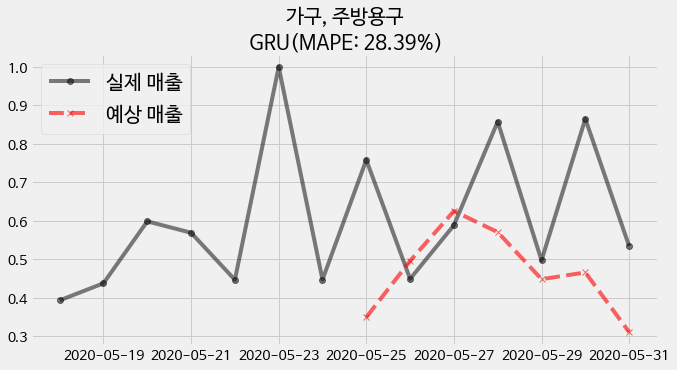

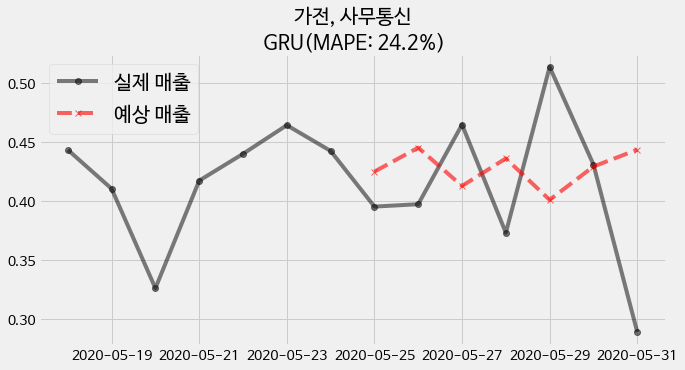

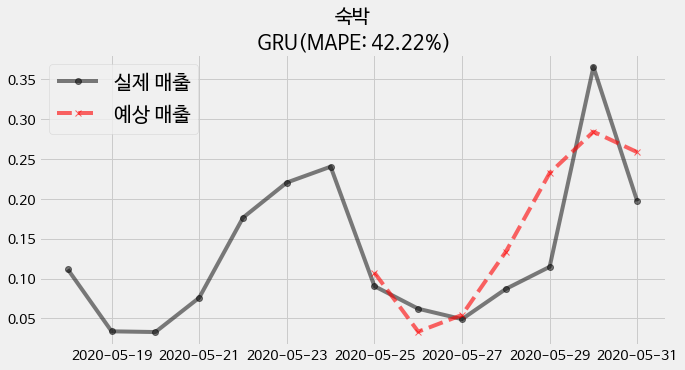

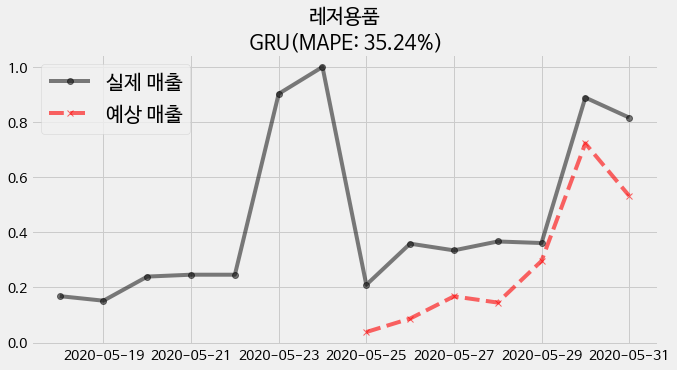

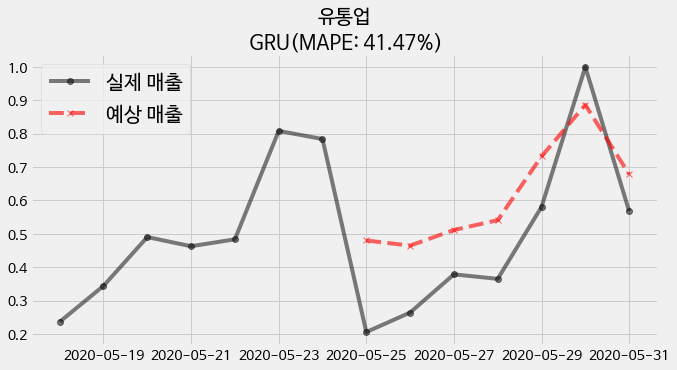

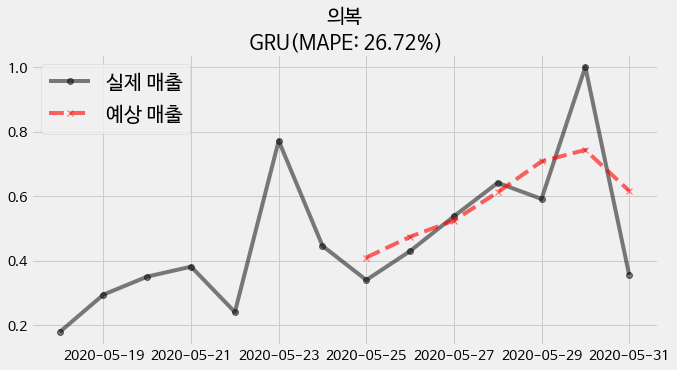

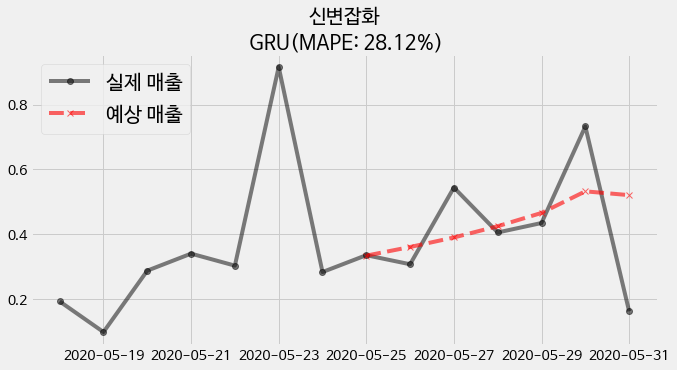

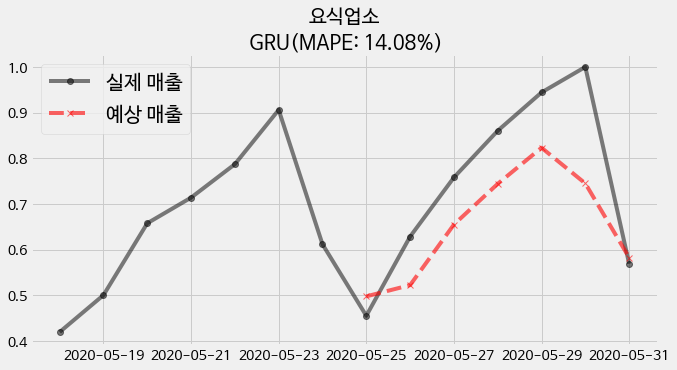

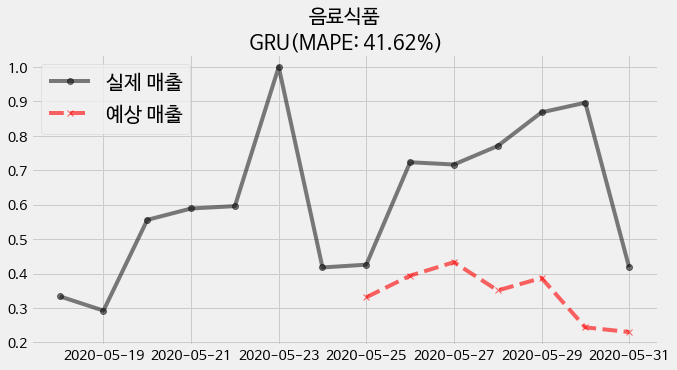

In [28]:
dates = covid.STD_DD.values[-14:]
names = ['가구, 주방용구', '가전, 사무통신', '숙박', '레저용품', '유통업', '의복', '신변잡화', '요식업소', '음료식품']

for i in range(9):
    # 5/17 ~ 5/31의 실제 매출
    real_amt = list(train_y[i]) + list(test_y[i]) 
    # 5/25 ~ 5/31 예상 매출
    pred_amt = gru_pred[i]

    plt.figure(figsize=(10,5))
    plt.plot(dates, real_amt, marker = 'o', color = 'black', label = '실제 매출', alpha = 0.5)
    plt.plot(dates[7:], pred_amt, color = 'red', label = '예상 매출', marker = 'x', ls = '--', alpha = 0.6)
    plt.legend(loc = 'upper left', fontsize = 'x-large')
    plt.title(f"{names[i]}\n GRU(MAPE: {round(gru_score[i], 2)}%)", size = 20)
    plt.show()

# 각 카테고리별 모델 비교

In [29]:
pd.DataFrame({'category': names,
              'XGBoost': xgb_score,
              'LSTM': lstm_score,
              'GRU': gru_score})

,category,XGBoost,LSTM,GRU
0,"가구, 주방용구",31.004594,34.484448,28.390777
1,"가전, 사무통신",16.993220,13.308218,24.204267
2,숙박,21.830315,39.441548,42.215003
3,레저용품,23.188637,28.204319,35.242969
4,유통업,11.329862,41.352162,41.467129
5,의복,26.077631,27.305265,26.716778
6,신변잡화,24.414457,32.934370,28.122494
7,요식업소,11.032990,16.970403,14.078932
8,음료식품,24.308267,35.998465,41.619599
